# 🎯 Objective¶¶
The goal of this project is to develop a model capable of classifying ultrasonic sounds emitted by plants under various stress conditions. This approach aims to provide insights into plant health by recognizing specific stress signals, enabling early and non-invasive monitoring of plant conditions in environments such as agriculture and research.

# 📁 Dataset¶¶
Recorded Plant Sounds from: Sounds emitted by plants under stress are airborne and informative. Includes recordings of plant sounds emitted from stressed plants, and sounds from empty environments Each directory consists of .wav files that are recordings of sounds according to the directory's name (e.g. Tomato Dry - sounds from tomatoes experiencing a drought stress). The wav files' names are of the format id_sound, were plant_id is an identifier of the plant recorded, and sound_id is an incrementing identifier of the sound recorded per plant_id. If the recording isn't of a plant (e.g. Empty Pot), the plant_id represents a recording instance. .

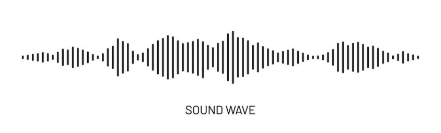

# Dataset preparation

In [1]:
import os
import numpy as np

def get_file_paths_and_labels(directory):
    file_paths = []
    labels = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):  # Adjust extension if needed
                file_paths.append(os.path.join(root, file))
                # Extract label from directory name
                class_name = os.path.basename(root)
                labels.append(class_name)
    return file_paths, labels

# Directory containing audio files
data_dir = '/kaggle/input/dataset1/PlantSound'

# Get file paths and labels
file_paths, labels = get_file_paths_and_labels(data_dir)


# Importing libaries 

In [2]:
pip install gammatone


Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import tensorflow as tf
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import lfilter

# Splitting Data

In [4]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train_files, X_test_files, y_train_labels, y_test_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42
)


In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train_labels)
y_test = le.transform(y_test_labels)


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

# Feature extraction

In [7]:
import numpy as np
import librosa
import os

def extract_features(file_paths):
    """Extract features from audio files without adding any noise."""
    features = []
    for file in file_paths:
        y, sr = librosa.load(file, sr=None)
        # Extract MFCC features from the clean audio
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfccs = np.mean(mfccs, axis=1)
        features.append(mfccs)
    return np.array(features)  # Reshape to 2D format (height=1, width=13, channels=1)

# Extract features for train and test files without noise addition
X_train_features = extract_features(X_train_files)
X_test_features = extract_features(X_test_files)

# Reshape to 2D format (height=1, width=13, channels=1)
X_train_features = X_train_features.reshape((X_train_features.shape[0], 1, X_train_features.shape[1], 1))
X_test_features = X_test_features.reshape((X_test_features.shape[0], 1, X_test_features.shape[1], 1))

# Proceed to train your model with X_train_features and X_test_features


/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1001
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


# MODEL BUILDING

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, GlobalMaxPooling2D,
                                     Dense, Dropout, BatchNormalization, 
                                     LeakyReLU, Input, Add)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def residual_block(x, filters, kernel_size=(1, 3), strides=1, use_batchnorm=True):
    """Residual block with two Conv2D layers and optional 1x1 convolution for matching dimensions."""
    # Shortcut connection (residual path)
    res = x
    
    # First Conv layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_regularizer=l2(1e-4))(x)
    if use_batchnorm:
        x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    # Second Conv layer
    x = Conv2D(filters, kernel_size=kernel_size, padding='same', kernel_regularizer=l2(1e-4))(x)
    if use_batchnorm:
        x = BatchNormalization()(x)
    
    # Use a 1x1 convolution on the residual path to match the number of filters
    if res.shape[-1] != x.shape[-1]:
        res = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same', kernel_regularizer=l2(1e-4))(res)
    
    # Add residual connection
    x = Add()([x, res])
    x = LeakyReLU(alpha=0.1)(x)
    
    return x

# Adjust the input shape based on your dataset
input_shape = (1, 13, 1)  

inputs = Input(shape=input_shape)
x = BatchNormalization()(inputs)
x = Conv2D(64, (1, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = residual_block(x, 64)
x = MaxPooling2D(pool_size=(1, 2))(x)
x = Dropout(0.3)(x)
x = residual_block(x, 128)
x = MaxPooling2D(pool_size=(1, 2))(x)
x = Dropout(0.3)(x)
x = residual_block(x, 256)
x = residual_block(x, 256) 
# Global MaxPooling for extracting the most important features
x = GlobalMaxPooling2D()(x)
x = Dropout(0.4)(x)
# Fully connected layers
x = Dense(512, kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.5)(x)
# Output layer 
outputs = Dense(len(le.classes_), activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = Adam(learning_rate=0.0001)  # Reduced learning rate for better convergence
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 13, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1, 13, 1)  │          4 │ input_layer[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1, 13, 64) │        256 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 13, 64) │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 1, 13, 64) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1, 13, 64) │     12,352 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 13, 64) │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 1, 13, 64) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 13, 64) │     12,352 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 13, 64) │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 13, 64) │          0 │ batch_normalizat… │
│                     │                   │            │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 1, 13, 64) │          0 │ add[0][0]         │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 1, 6, 64)  │          0 │ leaky_re_lu_2[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1, 6, 64)  │          0 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 1, 6, 128) │     24,704 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 6, 128) │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 1, 6, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 1, 6, 128) │     49,280 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 6, 128) │        512 │ conv2d_4[0][0]  

 Total params: 972,042 (3.71 MB)

 Trainable params: 968,072 (3.69 MB)

 Non-trainable params: 3,970 (15.51 KB)

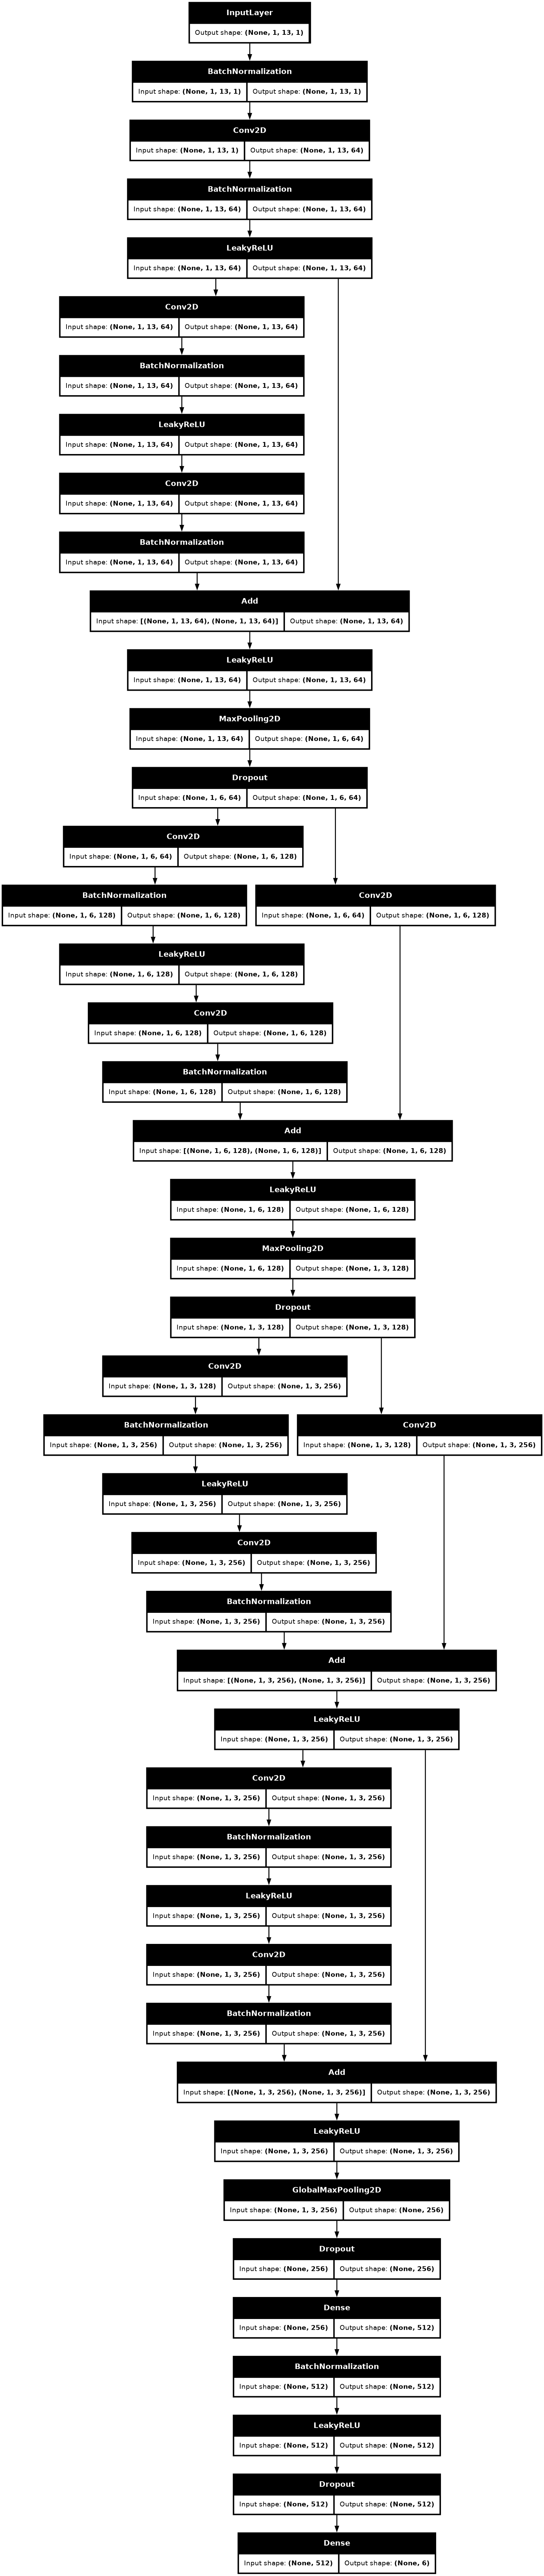

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, dpi=100)

In [9]:
# Define callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Model training

In [10]:
history = model.fit(
    X_train_features, y_train,
    batch_size=32,
    epochs=80,
    validation_data=(X_test_features, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/80
187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.2297 - loss: 2.4462 - val_accuracy: 0.1854 - val_loss: 2.8819 - learning_rate: 1.0000e-04
Epoch 2/80
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.3471 - loss: 1.9621 - val_accuracy: 0.1941 - val_loss: 2.9076 - learning_rate: 1.0000e-04
Epoch 3/80
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.3875 - loss: 1.7847 - val_accuracy: 0.3762 - val_loss: 1.6798 - learning_rate: 1.0000e-04
Epoch 4/80
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.4310 - loss: 1.6385 - val_accuracy: 0.4411 - val_loss: 1.4167 - learning_rate: 1.0000e-04
Epoch 5/80
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.4574 - loss: 1.5481 - val_accuracy: 0.4518 - val_loss: 1.4336 - learning_rate: 1.0000e-04
Epoch 6/80
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.4676 - loss: 1.4910 - val_accuracy: 0.4766 - val_loss: 1.3124 - learning_rate: 1.0000e-04
Epoch 7/80
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - ac

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Evaluation of model

In [11]:
train_loss, train_accuracy = model.evaluate(X_train_features, y_train, verbose=0)
print(f"Final Train Loss: {train_loss:.4f}")
print(f"Final Train Accuracy: {train_accuracy:.4f}")


Final Train Loss: 1.0598
Final Train Accuracy: 0.6279


In [12]:
test_loss, test_accuracy = model.evaluate(X_test_features, y_test, verbose=0)
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")


Final Test Loss: 1.1052
Final Test Accuracy: 0.5904


**Accuracy and loss graphs**

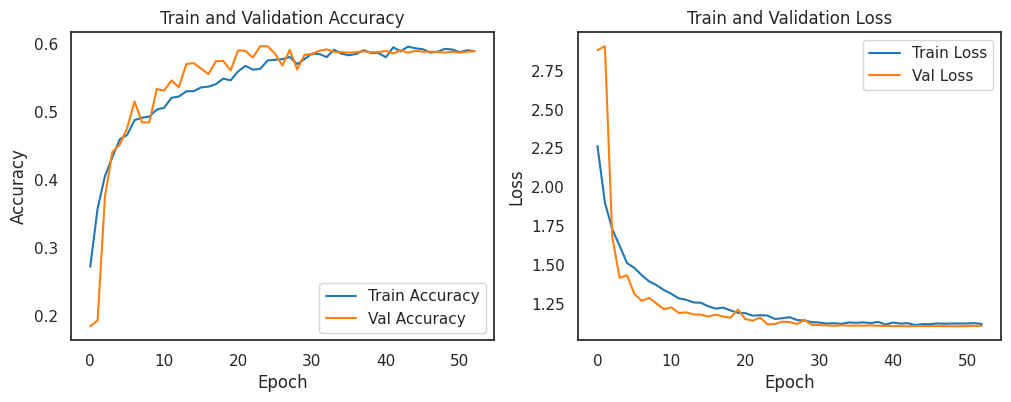

In [18]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')

plt.show()

**Confusion matrix**

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


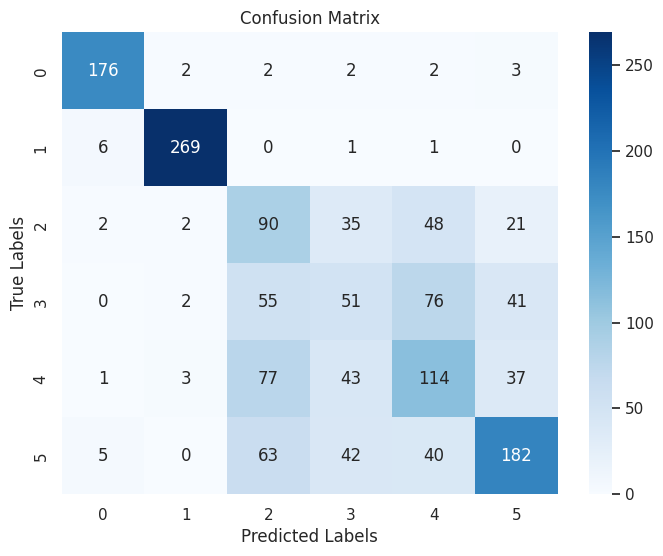

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test_features)

# If you're doing classification, make sure to convert predictions to the same format as y_test
# If your model outputs probabilities (e.g., in a classification problem), we take the class with the highest probability
y_pred_classes = np.argmax(y_pred, axis=1)  # For multi-class classification (if needed)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Precision per class:  [0.92631579 0.9676259  0.31358885 0.29310345 0.40569395 0.64084507]
Recall per class:  [0.94117647 0.97111913 0.45454545 0.22666667 0.41454545 0.54819277]
F1 Score per class:  [0.933687   0.96936937 0.37113402 0.2556391  0.41007194 0.59090909]
Macro-average Precision:  0.5911955013008016
Macro-average Recall:  0.5927076585006926
Macro-average F1 Score:  0.5884684206233235


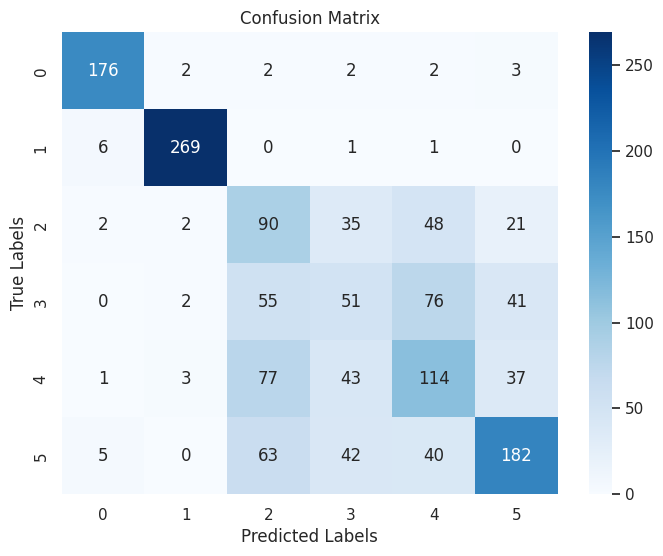

In [14]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the test set
y_pred = model.predict(X_test_features)

# If your model outputs probabilities, convert them to class labels
y_pred_classes = np.argmax(y_pred, axis=1)  # For multi-class classification (if needed)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_test, y_pred_classes, average=None)  # per class
recall = recall_score(y_test, y_pred_classes, average=None)  # per class
f1 = f1_score(y_test, y_pred_classes, average=None)  # per class

# For micro/macro average (optional), use:
precision_macro = precision_score(y_test, y_pred_classes, average='macro')
recall_macro = recall_score(y_test, y_pred_classes, average='macro')
f1_macro = f1_score(y_test, y_pred_classes, average='macro')

# Print the metrics
print("Precision per class: ", precision)
print("Recall per class: ", recall)
print("F1 Score per class: ", f1)
print("Macro-average Precision: ", precision_macro)
print("Macro-average Recall: ", recall_macro)
print("Macro-average F1 Score: ", f1_macro)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [28]:
test_files = [
    ("/kaggle/input/dataset1/PlantSound/Tobacco Dry/id_11_sound_12.wav","Tomato Cut"),
    ("/kaggle/input/dataset1/PlantSound/Tomato Cut/id_123_sound_5.wav","Tomato Dry"),
    
]

In [29]:
def make_predictions(model, le, file_path):
    audio, sample_rate = librosa.load(file_path, sr=22050)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    mfccs_scaled = np.mean(mfccs.T, axis=0)
    features = mfccs_scaled.reshape(1, 1, 13, 1)
    predicted_vector = model.predict(features)
    predicted_class_index = np.argmax(predicted_vector, axis=-1)
    return le.inverse_transform(predicted_class_index)[0]


In [30]:
# Iterate through test files and print predictions
for file_path, true_label in test_files:
    predicted_label = make_predictions(model, le, file_path)
    print(f"File: {file_path}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print("-" * 30)  


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=45
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=45
  warnings.warn(


File: /kaggle/input/dataset1/PlantSound/Tobacco Dry/id_11_sound_12.wav
True Label: Tomato Cut
Predicted Label: Tomato Dry
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
File: /kaggle/input/dataset1/PlantSound/Tomato Cut/id_123_sound_5.wav
True Label: Tomato Dry
Predicted Label: Tomato Dry
------------------------------
